# Setup Paths

In [2]:
import os

In [3]:
CUSTOM_MODEL_NAME = 'tuned-model' 
PRETRAINED_MODEL_NAME = 'efficientdet_d0_coco17_tpu-32'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz' #tf-zoo
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [22]:
paths = {
    'WORKSPACE_PATH': '../',
    'SCRIPTS_PATH': '../src',
    'APIMODEL_PATH': '../src/models',
    'ANNOTATION_PATH': '../src/annotations',
    'IMAGE_PATH': '../data/processed',
    'MODEL_PATH': '../models',
    'PRETRAINED_MODEL_PATH': '../models/pre-trained-models',
    'CHECKPOINT_PATH': os.path.join('../models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('../models',CUSTOM_MODEL_NAME, 'export'), 
 }

In [23]:
files = {
    'PIPELINE_CONFIG':os.path.join('../models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [24]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [7]:
# Install Tensorflow Object Detection
## pacman for arch linux or apt-get for ubuntu or debian

# !pacman -S protobuf
# !apt-get install protobuf-compiler 
!cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install -q . 

In [19]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2024-05-25 10:30:10.876009: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 10:30:10.906597: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 10:30:10.907019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 10:30:11.609162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Running tests under Python 3.10.0: /home/tinapyp/Dependencies/miniconda3/envs/tfod/bin/python
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
W0525 10:30:13.152276 125022409188544 batch_normalization.py:1531] `tf.keras.layers.experimental.SyncBatchNormalization` endpoint is d

In [6]:
import object_detection

In [21]:
# Download Model from TF Zoo
!wget {PRETRAINED_MODEL_URL}
!mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
!cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2024-05-25 10:30:35--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 34.101.5.59, 34.101.5.91, 142.251.223.27, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|34.101.5.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M  2.05MB/s    in 15s     

2024-05-25 10:30:51 (1.96 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]

efficientdet_d0_coco17_tpu-32/
efficientdet_d0_coco17_tpu-32/checkpoint/
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d0_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d0_coco17_tpu-32/pipeline.config
efficientdet_d0_coco17_tpu-32/saved_model/
efficient

# 2. Create Label Map

In [35]:
labels = [
    {"name": 'biskuit-selamat', "id": 1},
    {"name": 'chitato-lite', "id": 2},
    {"name": 'chitato-sapi', "id": 3},
    {"name": 'fitbar', "id": 4},
    {"name": 'pocari', "id": 5},
    {"name": 'nissin-cracker', "id": 6},
    {"name": 'popmie', "id": 7},
    {"name": 'roma-kelapa', "id": 8},
    {"name": 'teh-botol', "id": 9},
    {"name": 'twist', "id": 10}
]

with open(files["LABELMAP"], "w") as f:
    for label in labels:
        f.write("item { \n")
        f.write("\tname:'{}'\n".format(label["name"]))
        f.write("\tid:{}\n".format(label["id"]))
        f.write("}\n")

# 3. Create TF records

In [8]:
# # OPTIONAL IF RUNNING ON COLAB
# ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
# if os.path.exists(ARCHIVE_FILES):
#   !tar -zxvf {ARCHIVE_FILES}

In [9]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [10]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 4. Copy Model Config to Training Folder

In [11]:
!cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning

In [29]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [31]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [37]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [38]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [39]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [40]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [41]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [42]:
print(command)

python ../src/models/research/object_detection/model_main_tf2.py --model_dir=../models/tuned-model --pipeline_config_path=../models/tuned-model/pipeline.config --num_train_steps=2000


In [20]:
!{command}

2024-05-25 10:33:08.348860: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 10:33:08.379219: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 10:33:08.379677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 10:33:09.060029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
I0525 10:33:10.616311 135499983955136 mirrored_strategy.py:419] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Maybe overwriting train_

# 7. Evaluate the Model

In [43]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [44]:
print(command)

python ../src/models/research/object_detection/model_main_tf2.py --model_dir=../models/tuned-model --pipeline_config_path=../models/tuned-model/pipeline.config --checkpoint_dir=../models/tuned-model


In [41]:
!{command}

2024-05-25 11:28:30.029582: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 11:28:30.070772: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 11:28:30.071442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 11:28:30.863821: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
W0525 11:28:32.462214 129003168306688 model_lib_v2.py:1089] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0525 11:28:32.462358 129003168306688 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: N

# 8. Load Train Model From Checkpoint

In [21]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [22]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [23]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [24]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [28]:
IMAGE_PATH = "/home/tinapyp/Work/FastWork/tfod-efficientdet2/data/raw/data uji/1_object/IMG_2510.jpg"

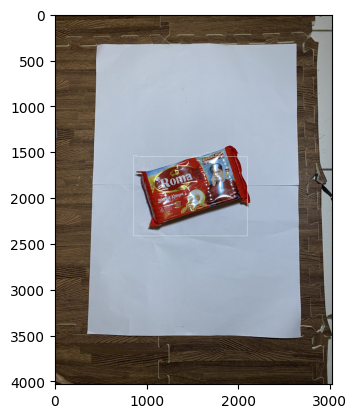

In [33]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.4,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Real Time Detections from using Webcam

In [ ]:
!pip uninstall opencv-python-headless -y

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# Freezing the Graph

In [45]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [46]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [47]:
print(command)

python ../src/models/research/object_detection/exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=../models/tuned-model/pipeline.config --trained_checkpoint_dir=../models/tuned-model --output_directory=../models/tuned-model/export


In [37]:
!{command}

2024-05-25 11:25:40.792534: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 11:25:41.007491: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 11:25:41.008371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 11:25:42.024355: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0525 11:25:43.906961 126730998027776 ssd_efficientnet_bifpn_feature_extractor.py:161] EfficientDet EfficientNet backbone version: efficientnet-b0
I0525 11:25:43.907092 126730998027776 ssd_efficientnet_bifpn_feature_extractor.py:163] EfficientDet BiFPN num filters: 64
I0525 11:25:43.907127 1

# Zip and Export Models 

In [38]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}